# 3.6 human-in-the-loop: 사람이 Agent와 소통하는 방법

- AI는 100%의 정확도를 보장하지 않기 때문에, 경우에 따라 사람의 개입이 필요합니다
- LangGraph의 [`interrupt`](https://langchain-ai.github.io/langgraph/cloud/how-tos/interrupt_concurrent/) 를 사용하여 사람의 개입을 처리할 수 있습니다

HIP의 예
- Approve or Reject
- Review & Edit state
- Review Tool Calls

Review Tool Calls의 사람 체크 요소
- 그냥 go
- 도구는 잘 골랐으나 query 이상
- 도구 자체를 잘못 고른 경우

이를 위해 Interrupt와 Command(진행) 클래스를 사용한다.

Interrupt를 사용하려면 checkpointer가 반드시 필요하다.   
정지된 시점을 기억했다가 진행해야하기 때문이다.  
checkpointer 없이 Interrupt를 사용하면 에러 발생

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

small_llm = ChatOpenAI(model="gpt-4o-mini")

In [3]:
from langchain_core.tools import tool


@tool
def add(a: int, b: int) -> int:
    """숫자 a와 b를 더합니다."""
    return a + b


@tool
def multiply(a: int, b: int) -> int:
    """숫자 a와 b를 곱합니다."""
    return a * b

In [4]:
from langchain_community.tools import DuckDuckGoSearchRun

search_tool = DuckDuckGoSearchRun()

In [5]:
from langchain_google_community import GmailToolkit

from langchain_google_community.gmail.utils import (
    build_resource_service,
    get_gmail_credentials,
)

# Can review scopes here https://developers.google.com/gmail/api/auth/scopes
# For instance, readonly scope is 'https://www.googleapis.com/auth/gmail.readonly'
credentials = get_gmail_credentials(
    token_file="./google/gmail_token.json",
    scopes=["https://mail.google.com/"],
    client_secrets_file="./google/gmail_credentials.json",
)
api_resource = build_resource_service(credentials=credentials)
gmail_toolkit = GmailToolkit(api_resource=api_resource)
gmail_tool_list = gmail_toolkit.get_tools()

In [6]:
gmail_tool_list

[GmailCreateDraft(api_resource=<googleapiclient.discovery.Resource object at 0x12a706240>),
 GmailSendMessage(api_resource=<googleapiclient.discovery.Resource object at 0x12a706240>),
 GmailSearch(api_resource=<googleapiclient.discovery.Resource object at 0x12a706240>),
 GmailGetMessage(api_resource=<googleapiclient.discovery.Resource object at 0x12a706240>),
 GmailGetThread(api_resource=<googleapiclient.discovery.Resource object at 0x12a706240>)]

In [7]:
from langchain.agents import load_tools

loaded_tool_list = load_tools(
    ["arxiv"],
)

In [8]:
import os

from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_core.tools.retriever import create_retriever_tool

embedding_function = OpenAIEmbeddings(
    model="text-embedding-3-large",
)
vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name="real_estate_tax",
    persist_directory="./real_estate_tax_collection",
)
retriever = vector_store.as_retriever(search_kwargs={"k": 3})
retriever_tool = create_retriever_tool(
    retriever=retriever,
    name="real_estate_tax_retriever",
    description="Contains information about real estate tax up to December 2024",
)

In [9]:
from langgraph.prebuilt import ToolNode

tool_list = (
    [add, multiply, search_tool, retriever_tool] + gmail_tool_list + loaded_tool_list
)
llm_with_tools = small_llm.bind_tools(tool_list)
tool_node = ToolNode(tool_list)

In [10]:
from langgraph.graph import MessagesState, StateGraph


class AgentState(MessagesState):
    summary: str


graph_builder = StateGraph(AgentState)

In [11]:
from langchain_core.messages import SystemMessage


def agent(state: AgentState) -> AgentState:
    """
    이 에이전트 함수는 주어진 상태에서 메시지를 가져와
    LLM과 도구를 사용하여 응답 메시지를 생성합니다.

    Args:
        state (MessagesState): 메시지 기록과 요약을 포함하는 상태.

    Returns:
        MessagesState: 응답 메시지를 포함하는 새로운 상태.
    """
    messages = state["messages"]
    summary = state["summary"]
    if summary != "":
        messages = [
            SystemMessage(
                content=f"Here is the summary of the earlier conversation: {summary}"
            )
        ] + messages
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

사람이 리뷰하고 관여하는 humman_review 노드 추가

- `interrupt`에는 사용자에게 보여주고자 하는 메시지를 dictionary 형태로 작성합니다

In [13]:
from typing import Literal
from langgraph.types import interrupt, Command


def human_review(state: AgentState) -> Command[Literal["tools", "agent"]]: # return value를 잘 정의해야 그래프라 잘 그려짐
    """
    human_review node는 LLM의 도구 호출에 대해 사람의 검토를 요청합니다.

    Args:
        state (AgentState): 메시지 기록을 포함하는 state.

    Returns:
        Command: 다음 node로 이동하기 위한 Command를 반환합니다.
    """
    messages = state["messages"]
    last_message = messages[-1]
    tool_call = last_message.tool_calls[-1]
    human_review = interrupt(
        {"question": "이렇게 진행하면 될까요?", "tool_call": tool_call}
    )
    review_action = human_review["action"]
    # action은 3가지가 있은: 잘한경우/ 도구는 잘골랐으나 args가 잘못된경우/ 도구가 잘못골라진 경우
    review_data = human_review.get("data", None) # 도구호출시 사용할 args, query를 담는곳
    # get을 사용하는 이유,
    # llm이 잘한 경우에는 "data" 키가 없을 것이다. 이를 고려해 None을 넣어줌

    if review_action == "continue":
        # 에이전트의 판단이 맞다면, 도구를 사용하기 위해 아무것도 수정하지 않고 `tools` 노드로 이동합니다
        return Command(goto="tools")

    if review_action == "update_args":
        # 도구를 더 효율적으로 사용하기 위해 AIMessage의 `tool_calls` 필드를 업데이트합니다
        updated_ai_message = {
            "id": last_message.id,
            "role": "ai",
            "content": last_message.content,
            "tool_calls": [
                {"id": tool_call["id"], "name": tool_call["name"], "args": review_data}
            ],
        }
        return Command(goto="tools", update={"messages": [updated_ai_message]})

    if review_action == "update_tool":
        # 다른 도구를 사용하기 위해 `ToolMessage`를 업데이트합니다
        updated_tool_message = {
            "tool_call_id": tool_call["id"],
            "name": tool_call["name"],
            "role": "tool",
            "content": review_data,
        }
        return Command(goto="agent", update={"messages": [updated_tool_message]})

In [14]:
def summarize_messages(state: AgentState):
    """
    주어진 state의 메시지를 요약합니다.

    Args:
        state (AgentState): 메시지와 요약을 포함하는 state.

    Returns:
        AgentState: 요약된 메시지를 포함하는 딕셔너리.
    """
    messages = state["messages"]
    summary = state["summary"]
    summary_prompt = f"summarize this chat history below: \n\nchat_history:{messages}"
    if summary != "":
        summary_prompt = f"""summarize this chat history below while looking at the summary of earlier conversations
chat_history:{messages}
summary:{summary}"""

    summary = small_llm.invoke(summary_prompt)
    response = llm_with_tools.invoke(messages)
    return {"summary": response.content}

In [15]:
from langchain_core.messages import RemoveMessage


def delete_messages(state: AgentState):
    """
    주어진 state에서 오래된 메시지를 삭제합니다.

    Args:
        state (AgentState): 메시지를 포함하는 state.

    Returns:
        AgentState: 삭제된 메시지를 포함하는 새로운 state.
    """
    messages = state["messages"]
    delete_messages = [RemoveMessage(id=message.id) for message in messages[:-3]]
    return {"messages": delete_messages}

In [16]:
def should_continue(state: MessagesState):
    """
    주어진 state에 따라 다음 단계로 진행할지를 결정합니다.

    Args:
        state (AgentState): 메시지와 도구 호출 정보를 포함하는 state.

    Returns:
        Literal['tools', 'summarize_messages']: 다음 단계로 'tools' 또는 'summarize_messages'를 반환합니다.
    """
    messages = state["messages"]
    last_ai_message = messages[-1]
    if last_ai_message.tool_calls:
        return "human_review"

    return "summarize_messages"

- `node`를 추가하고 `edge`로 연결합니다

In [17]:
graph_builder.add_node("agent", agent)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node(human_review)
graph_builder.add_node(delete_messages)
graph_builder.add_node(summarize_messages)

In [18]:
from langgraph.graph import START, END


graph_builder.add_edge(START, "agent")
graph_builder.add_conditional_edges(
    "agent", should_continue, ["human_review", "summarize_messages"]
)
graph_builder.add_edge("tools", "agent")
graph_builder.add_edge("summarize_messages", "delete_messages")
graph_builder.add_edge("delete_messages", END)

- `interrupt`로 중단된 시점부터 다시 워크플로우를 재개하기 위해 `checkpointer`가 필요합니다

In [19]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()

graph = graph_builder.compile(checkpointer=checkpointer)

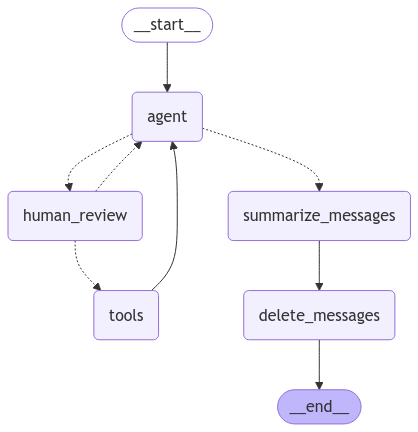

In [20]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "summarize_paper"}}

query = "LLM Survey 논문의 내용을 검색해서 요약해주세요"
for chunk in graph.stream(
    {"messages": [HumanMessage(query)], "summary": ""},
    config=config,
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

LLM Survey 논문의 내용을 검색해서 요약해주세요
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_xSLLYCSjCB8Oz1eBi9LY0l99)
 Call ID: call_xSLLYCSjCB8Oz1eBi9LY0l99
  Args:
    query: LLM Survey


In [23]:
for chunk in graph.stream(
    Command(resume={"action": "update_tool", "data": "arxiv말고 web에서 검색해주세요"}),
    config,
    stream_mode="updates",
):
    print(chunk)

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_wDAbNibHeO6gFk3mMDBBaUOS', 'function': {'arguments': '{"query":"LLM Survey 논문 요약"}', 'name': 'duckduckgo_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 779, 'total_tokens': 802, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_5154047bf2', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'tool_calls

In [24]:
for chunk in graph.stream(
    Command(resume={"action": "continue"}),
    config,
    stream_mode="updates",
):
    print(f"chunk == {chunk}")

chunk == {'human_review': None}


/Users/jasonkang/.pyenv/versions/3.12.2/envs/inflearn-langgraph-lecture/lib/python3.12/site-packages/langchain_community/utilities/duckduckgo_search.py:64: UserWarning: 'api' backend is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


chunk == {'tools': {'messages': [ToolMessage(content='단어 시퀀스에서 다음 단어를 예측하는 분야인 언어 모델링 (LM)은 크게 4가지 발전 단계로 나눌 수 있습니다: 통계적 언어 모델링 (SLM): 1990년대부터 사용된 방법으로, 간단한 n-그램 모델이 최근 문맥을 기반으로 다음 단어를 예측합니다 (마르코프 가정). 신경망 언어 모델 (NLM): RNN, LSTM, GRU, word2vec과 같은 신경망을 사용합니다. The paper describes 3 characteristics of LLMs that differentiate them from PLMs: 이 논문에서는 새로운 데이터셋을 개발하고, 다섯 가지 다른 요약 작업에 대한 LLMs의 요약 생성 능력을 평가하기 위해 인간 평가 실험을 수행하였습니다. 실험 결과, LLMs가 생성한 요약은 인간이 작성한 요약보다 더 많은 사실적 일관성과 외생적 환각 (extrinsic hallucinations)이 적은 것으로 나타났습니다. 이 논문은 텍스트 요약 분야에서 LLMs의 활용 가능성을 보여주며, 미래에는 더 높은 품질의 데이터셋과 평가 방법을 개발하여 텍스트 요약 분야에서 더 나은 성과를 이루기 위한 연구가 필요하다는 결론을 내리고 있습니다. ELMO는 고정된 단어 representation 대신 양방향 LSTM (biLSTM)을 사전학습해서 문맥을 잘 아는 단어 표현을 포착하도록 고안되었다. Self attention 메커니즘은 병렬처리가 가능한 Transformer 아키텍쳐 기반으로 BERT는 대량의 unlabeled copora로 양방향의 언어모델을 사전학습한다. 사전학습 된 context-aware word representation은 문맥적인 feature로 매우 효과적이다. LLM. GPT-3는 incontext learning을 통해 few shot task를 해결한다. 1. 이 리뷰 논문은 대규모 언어 모델의 한계를 극복하기 위해 검색-증강 생성 

In [25]:
graph.get_state(config).values["messages"]

[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_wDAbNibHeO6gFk3mMDBBaUOS', 'function': {'arguments': '{"query":"LLM Survey 논문 요약"}', 'name': 'duckduckgo_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 779, 'total_tokens': 802, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_5154047bf2', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'tool_calls', 'logprobs': None, 'c

- 다시 볼것 